# Ensemble Classifiers: Expanded Featureset
---
Full featureset (26 features): ['gender', 'age', 'illday', 'eth', 'rash', 'redeyes', 'redplt', 'clnode',
       'redhands', 'peeling', 'pwbc', 'ppolys', 'pbands', 'plymphs', 'pmonos',
       'peos', 'abc', 'anc', 'zhemo', 'pplts', 'pesr', 'pcrp', 'palt', 'pggt',
       'palbumin', 'pua']

### Pre-Training Setup

In [1]:
import sys
sys.path.append('../') # Make parent folder visible
import numpy as np
from scipy.stats import randint

from sklearn import svm, linear_model, neighbors, ensemble, naive_bayes, \
    neural_network, tree, gaussian_process, discriminant_analysis
    
import matplotlib.pyplot as plt

from preprocess import load_data
from model_helpers.models import compute_confusion, explain_confusion, \
    test_model, plot_cv_roc_curves, ScikitModel

In [2]:
x, y, ids = load_data.load_expanded(one_hot=False, fill_mode='mean')

### Test out Candidate Learners

In [3]:
svm_rocs = test_model(ScikitModel(svm.SVC(probability=True), 
                       {
                           'C': np.logspace(-3, 3, 100),
                           'gamma': np.logspace(-3, 3, 100),
                           'kernel': ['linear', 'rbf', 'poly']
                       },
                       random_search=True,
                       n_iter=100,
                       scoring='roc_auc',
                       verbose=True),
                      x, y,
                      allow_indeterminates=True)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed: 11.8min finished


Best params:  {'kernel': 'linear', 'gamma': 1.0722672220103231, 'C': 0.0081113083078968723}
Best score:  0.983374353159
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed: 20.7min finished


Best params:  {'kernel': 'linear', 'gamma': 0.086974900261778343, 'C': 0.4641588833612782}
Best score:  0.977927095749
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:  5.9min finished


Best params:  {'kernel': 'linear', 'gamma': 0.037649358067924674, 'C': 0.0030538555088334154}
Best score:  0.982319552705
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed: 11.4min finished


Best params:  {'kernel': 'linear', 'gamma': 0.018738174228603841, 'C': 0.0046415888336127824}
Best score:  0.978232772243
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:  4.5min finished


Best params:  {'kernel': 'rbf', 'gamma': 0.0015199110829529332, 'C': 1.4174741629268048}
Best score:  0.981446265077
CV Confusion:  [(106, 7, 5, 141, 12, 18), (116, 8, 6, 157, 1, 1), (107, 7, 5, 148, 10, 11), (119, 8, 6, 160, 0, 0), (100, 7, 5, 146, 17, 13)]
Best CV scores:  [ 0.9834  0.9779  0.9823  0.9782  0.9814]
Avg best scores:  0.980660007787
FC Classified as FC: 548, (87.68 %)
FC Classified as KD: 37, (5.92 %)
KD Classified as FC: 27, (3.28467153285 %)
KD Classified as KD: 752, (91.4841849148 %)
FC left indeterminate: 40, (6.4 %)
KD left indeterminate: 43, (5.23114355231 %)
Avg specificity: 0.965340179718
Avg sensitivity: 0.936752136752


In [4]:
lr_rocs = test_model(ScikitModel(linear_model.LogisticRegression(), 
                       params={
                           'C': np.logspace(-2, 2, 5)
                       },
                       random_search=False,
                       scoring='roc_auc',
                       verbose=True),
           x, y,
           allow_indeterminates=True)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    0.2s finished


Best params:  {'C': 0.01}
Best score:  0.983330902425
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best params:  {'C': 0.01}
Best score:  0.97744783695


[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    0.2s finished


Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best params:  {'C': 1.0}
Best score:  0.982086419115


[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    0.2s finished


Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best params:  {'C': 0.10000000000000001}
Best score:  0.978113205694


[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    0.2s finished


Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best params:  {'C': 0.10000000000000001}
Best score:  0.981677474335


[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    0.2s finished


CV Confusion:  [(105, 7, 5, 141, 13, 18), (117, 8, 6, 160, 0, 0), (108, 7, 5, 135, 9, 24), (119, 8, 6, 160, 0, 0), (101, 7, 5, 145, 16, 14)]
Best CV scores:  [ 0.9833  0.9774  0.9821  0.9781  0.9817]
Avg best scores:  0.980531167703
FC Classified as FC: 550, (88.0 %)
FC Classified as KD: 37, (5.92 %)
KD Classified as FC: 27, (3.27669902913 %)
KD Classified as KD: 741, (89.927184466 %)
FC left indeterminate: 38, (6.08 %)
KD left indeterminate: 56, (6.79611650485 %)
Avg specificity: 0.96484375
Avg sensitivity: 0.936967632027


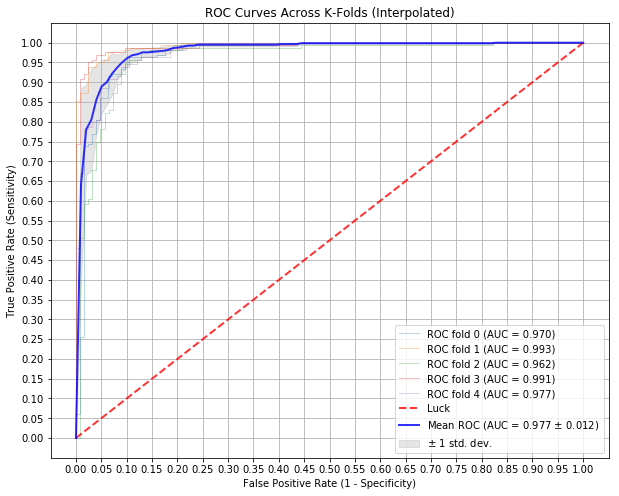

In [5]:
plot_cv_roc_curves(lr_rocs)

In [6]:
rf_rocs = test_model(ScikitModel(ensemble.RandomForestClassifier(), 
                       params={
                           'n_estimators': randint(10, 500),
                           'max_features': randint(3, 15),
                           'min_samples_split': randint(2, 50),
                           'min_samples_leaf': randint(1, 50)
                       },
                       random_search=True,
                       n_iter=250,
                       scoring='roc_auc',
                       verbose=True),
           x, y,
           allow_indeterminates=True)

Fitting 5 folds for each of 250 candidates, totalling 1250 fits


[Parallel(n_jobs=1)]: Done 1250 out of 1250 | elapsed: 12.1min finished


Best params:  {'max_features': 3, 'min_samples_leaf': 8, 'min_samples_split': 14, 'n_estimators': 137}
Best score:  0.98248727819
Fitting 5 folds for each of 250 candidates, totalling 1250 fits


[Parallel(n_jobs=1)]: Done 1250 out of 1250 | elapsed: 13.0min finished


Best params:  {'max_features': 5, 'min_samples_leaf': 1, 'min_samples_split': 6, 'n_estimators': 499}
Best score:  0.978180217193
Fitting 5 folds for each of 250 candidates, totalling 1250 fits


[Parallel(n_jobs=1)]: Done 1250 out of 1250 | elapsed: 11.5min finished


Best params:  {'max_features': 3, 'min_samples_leaf': 33, 'min_samples_split': 20, 'n_estimators': 162}
Best score:  0.981582779787
Fitting 5 folds for each of 250 candidates, totalling 1250 fits


[Parallel(n_jobs=1)]: Done 1250 out of 1250 | elapsed: 12.5min finished


Best params:  {'max_features': 3, 'min_samples_leaf': 8, 'min_samples_split': 14, 'n_estimators': 304}
Best score:  0.979160199104
Fitting 5 folds for each of 250 candidates, totalling 1250 fits


[Parallel(n_jobs=1)]: Done 1250 out of 1250 | elapsed: 12.1min finished


Best params:  {'max_features': 3, 'min_samples_leaf': 7, 'min_samples_split': 11, 'n_estimators': 440}
Best score:  0.982042848344
CV Confusion:  [(110, 7, 5, 143, 8, 16), (121, 8, 6, 160, 0, 0), (102, 7, 5, 149, 15, 10), (121, 8, 6, 160, 0, 0), (103, 6, 5, 147, 15, 12)]
Best CV scores:  [ 0.9825  0.9782  0.9816  0.9792  0.982 ]
Avg best scores:  0.980690664524
FC Classified as FC: 557, (88.2725832013 %)
FC Classified as KD: 36, (5.70522979398 %)
KD Classified as FC: 27, (3.27669902913 %)
KD Classified as KD: 759, (92.1116504854 %)
FC left indeterminate: 38, (6.02218700475 %)
KD left indeterminate: 38, (4.61165048544 %)
Avg specificity: 0.965648854962
Avg sensitivity: 0.939291736931


## Sklearn Ensemble Model

In [7]:
# Grid search params
clf1 = svm.SVC(probability=True)
clf2 = linear_model.LogisticRegression()

eclf = ensemble.VotingClassifier(
    estimators=[('svm', clf1), ('lr', clf2)],
    voting='soft')

params = {
    'svm__C': np.logspace(-3, 2, 100),
    'svm__gamma': np.logspace(-3, 2, 100),
    'svm__kernel': ['linear', 'rbf', 'poly'],
    'lr__C': np.logspace(-3, 2, 100)
}

# Test model! 5-fold CV with hyperparameter optimization
clf = ScikitModel(
    eclf,
    params,
    random_search=True, 
    n_iter=100, 
    verbose=True)

ensemble_rocs = test_model(clf, x, y, allow_indeterminates=True)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:  2.4min finished


Best params:  {'svm__kernel': 'linear', 'svm__gamma': 27.825594022071257, 'svm__C': 0.0025353644939701114, 'lr__C': 0.13219411484660287}
Best score:  0.983483625006
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:  2.0min finished


Best params:  {'svm__kernel': 'linear', 'svm__gamma': 0.0040370172585965534, 'svm__C': 22.051307399030456, 'lr__C': 0.0045348785081285817}
Best score:  0.978338961204
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:  2.4min finished


Best params:  {'svm__kernel': 'rbf', 'svm__gamma': 0.95454845666183374, 'svm__C': 0.025950242113997359, 'lr__C': 70.548023107186452}
Best score:  0.983584707995
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:  2.3min finished


Best params:  {'svm__kernel': 'rbf', 'svm__gamma': 0.036783797718286326, 'svm__C': 0.59948425031894093, 'lr__C': 0.21049041445120198}
Best score:  0.97891780934
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:  2.1min finished


Best params:  {'svm__kernel': 'rbf', 'svm__gamma': 27.825594022071257, 'svm__C': 39.442060594376564, 'lr__C': 0.036783797718286326}
Best score:  0.982137135975
CV Confusion:  [(106, 7, 5, 142, 12, 17), (116, 8, 6, 156, 1, 2), (106, 6, 5, 126, 12, 33), (120, 8, 6, 160, 0, 0), (101, 7, 5, 146, 16, 13)]
Best CV scores:  [ 0.9835  0.9783  0.9836  0.9789  0.9821]
Avg best scores:  0.981292447904
FC Classified as FC: 549, (87.6996805112 %)
FC Classified as KD: 36, (5.75079872204 %)
KD Classified as FC: 27, (3.28467153285 %)
KD Classified as KD: 730, (88.8077858881 %)
FC left indeterminate: 41, (6.54952076677 %)
KD left indeterminate: 65, (7.90754257908 %)
Avg specificity: 0.964332892999
Avg sensitivity: 0.938461538462


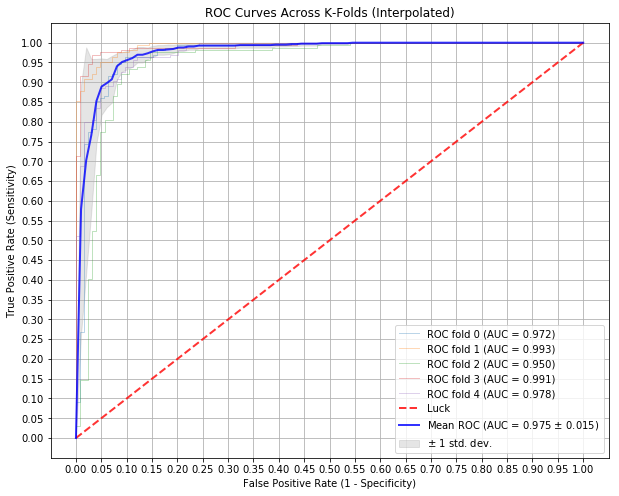

In [8]:
plot_cv_roc_curves(ensemble_rocs)